# Sidebet Optimizer v2

**TGOES - Theoretical Gameplay Optimization Engine Suite**

Bayesian survival analysis for optimal sidebet placement timing.

---

In [1]:
# =============================================================================
# CONFIGURATION - EDIT THESE VALUES
# =============================================================================

SIDEBET_WINDOW = 40  # Ticks for sidebet to win (default: 40)
PAYOUT_MULT = 5  # Payout multiplier (5x, 10x, or 20x)
BANKROLL = 0.1  # Your bankroll in SOL
KELLY_FRACTION = 0.25  # Fraction of Kelly to use (0.25 = quarter Kelly)

print(
    f"Configuration: {SIDEBET_WINDOW}-tick window, {PAYOUT_MULT}x payout, {BANKROLL} SOL bankroll"
)

Configuration: 40-tick window, 5x payout, 0.1 SOL bankroll


In [2]:
# =============================================================================
# IMPORTS & DATA LOADING
# =============================================================================
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Dark theme
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (14, 5)
plt.rcParams["font.family"] = "monospace"
plt.rcParams["axes.facecolor"] = "#1e1e2e"
plt.rcParams["figure.facecolor"] = "#1e1e2e"
plt.rcParams["axes.edgecolor"] = "#45475a"
plt.rcParams["axes.labelcolor"] = "#cdd6f4"
plt.rcParams["xtick.color"] = "#cdd6f4"
plt.rcParams["ytick.color"] = "#cdd6f4"
plt.rcParams["text.color"] = "#cdd6f4"
plt.rcParams["grid.color"] = "#45475a"
plt.rcParams["grid.alpha"] = 0.3

# Colors (Catppuccin Mocha)
C = {
    "red": "#f38ba8",
    "green": "#a6e3a1",
    "blue": "#89b4fa",
    "mauve": "#cba6f7",
    "yellow": "#f9e2af",
    "peach": "#fab387",
    "teal": "#94e2d5",
    "text": "#cdd6f4",
}

# Load data
GAMES_PATH = Path(
    "/home/devops/Desktop/VECTRA-PLAYER/src/rugs_recordings/PRNG CRAK/explorer_v2/data/games.json"
)
with open(GAMES_PATH) as f:
    games = json.load(f)

df = pd.DataFrame(games).rename(columns={"tick_duration": "rug_tick", "peak_multiplier": "peak"})
df = df[df["rug_tick"] >= 10]  # Filter very short games

print(f"Loaded {len(df):,} games")
print(
    f"Tick duration: min={df['rug_tick'].min()}, median={df['rug_tick'].median():.0f}, max={df['rug_tick'].max()}"
)
print(
    f"Peak multiplier: min={df['peak'].min():.2f}x, median={df['peak'].median():.2f}x, max={df['peak'].max():.2f}x"
)

Loaded 2,723 games
Tick duration: min=10, median=149, max=1815
Peak multiplier: min=1.00x, median=1.83x, max=1046.23x


In [3]:
# =============================================================================
# BAYESIAN SURVIVAL MODEL
# =============================================================================


class BayesianSurvivalModel:
    """Survival analysis for rug timing prediction."""

    def __init__(self, games_df):
        self.max_tick = int(games_df["rug_tick"].max()) + 1

        # Compute hazard: h(t) = P(rug at t | survived to t)
        rug_counts = np.zeros(self.max_tick)
        at_risk = np.zeros(self.max_tick)

        for rug_tick in games_df["rug_tick"]:
            rt = int(rug_tick)
            at_risk[: rt + 1] += 1
            if rt < self.max_tick:
                rug_counts[rt] += 1

        self.hazard = np.divide(rug_counts, at_risk, out=np.zeros(self.max_tick), where=at_risk > 0)
        self.hazard_smooth = np.convolve(self.hazard, np.ones(10) / 10, mode="same")

        # Survival function: S(t) = P(survives past t)
        self.survival = np.exp(-np.cumsum(self.hazard_smooth))

        # Store at-risk counts for confidence
        self.at_risk = at_risk

    def p_rug_in_window(self, tick, window=40):
        """P(rug in next `window` ticks | at tick t) = win probability for sidebet."""
        if tick >= len(self.survival) - 1:
            return 1.0
        s_now = self.survival[tick]
        s_future = self.survival[min(tick + window, len(self.survival) - 1)]
        return 1 - (s_future / s_now) if s_now > 0 else 0.5


model = BayesianSurvivalModel(df)
print(f"Model fitted: max_tick = {model.max_tick}")

Model fitted: max_tick = 1816


In [4]:
# =============================================================================
# EXPECTED VALUE FUNCTIONS
# =============================================================================


def ev(p_win, payout=5, bet=0.001):
    """Expected value: EV = bet * [p*(payout+1) - 1]"""
    return bet * (p_win * (payout + 1) - 1)


def breakeven(payout=5):
    """Breakeven probability = 1/(payout+1)"""
    return 1 / (payout + 1)


def kelly(p_win, payout=5):
    """Kelly criterion: f* = (p*b - q) / b where b=payout-1"""
    b = payout - 1
    return max(0, (p_win * b - (1 - p_win)) / b)


# Quick reference
print("Breakeven probabilities:")
for p in [5, 10, 20]:
    print(f"  {p}x payout: {breakeven(p):.2%}")

Breakeven probabilities:
  5x payout: 16.67%
  10x payout: 9.09%
  20x payout: 4.76%


---
## 1. Game Duration Distribution

How long do games last before rugging?

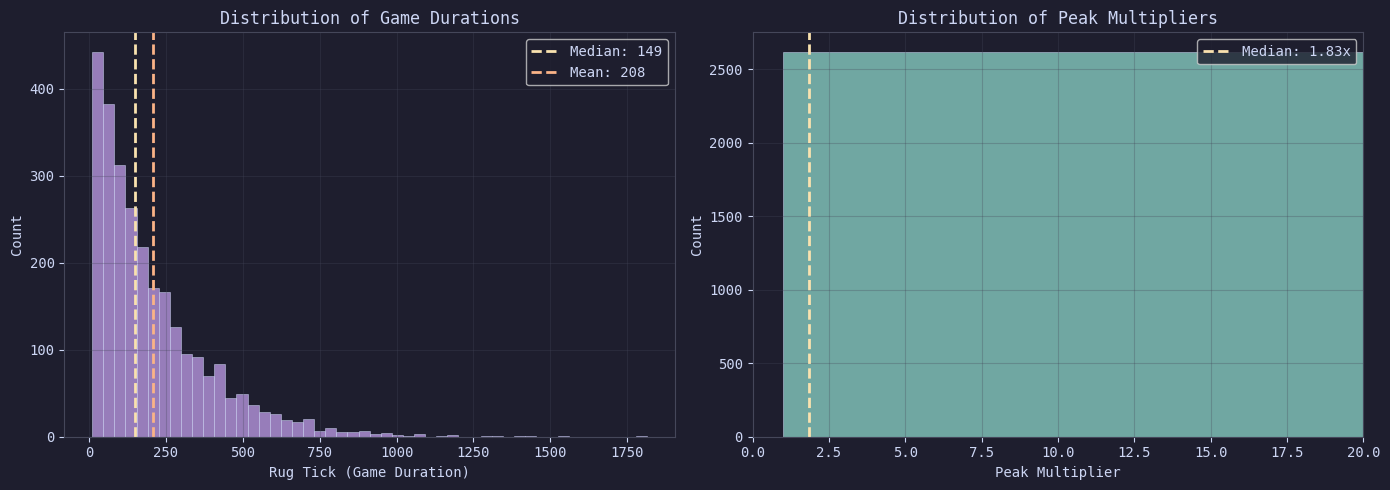


Game Duration Percentiles:
  25th percentile: 69 ticks
  50th percentile: 149 ticks
  75th percentile: 286 ticks
  90th percentile: 463 ticks
  95th percentile: 592 ticks
  99th percentile: 878 ticks


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of rug ticks
axes[0].hist(
    df["rug_tick"], bins=50, color=C["mauve"], alpha=0.7, edgecolor=C["text"], linewidth=0.5
)
axes[0].axvline(
    df["rug_tick"].median(),
    color=C["yellow"],
    linestyle="--",
    linewidth=2,
    label=f"Median: {df['rug_tick'].median():.0f}",
)
axes[0].axvline(
    df["rug_tick"].mean(),
    color=C["peach"],
    linestyle="--",
    linewidth=2,
    label=f"Mean: {df['rug_tick'].mean():.0f}",
)
axes[0].set_xlabel("Rug Tick (Game Duration)")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Game Durations")
axes[0].legend()
axes[0].grid(True)

# Histogram of peak multipliers (log scale)
axes[1].hist(df["peak"], bins=50, color=C["teal"], alpha=0.7, edgecolor=C["text"], linewidth=0.5)
axes[1].axvline(
    df["peak"].median(),
    color=C["yellow"],
    linestyle="--",
    linewidth=2,
    label=f"Median: {df['peak'].median():.2f}x",
)
axes[1].set_xlabel("Peak Multiplier")
axes[1].set_ylabel("Count")
axes[1].set_title("Distribution of Peak Multipliers")
axes[1].set_xlim(0, 20)  # Focus on common range
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Stats
print("\nGame Duration Percentiles:")
for p in [25, 50, 75, 90, 95, 99]:
    print(f"  {p}th percentile: {np.percentile(df['rug_tick'], p):.0f} ticks")

---
## 2. Survival Analysis

**Hazard Rate** $h(t)$: Probability of rugging at tick $t$, given game survived to $t$

**Survival Function** $S(t)$: Probability game survives past tick $t$

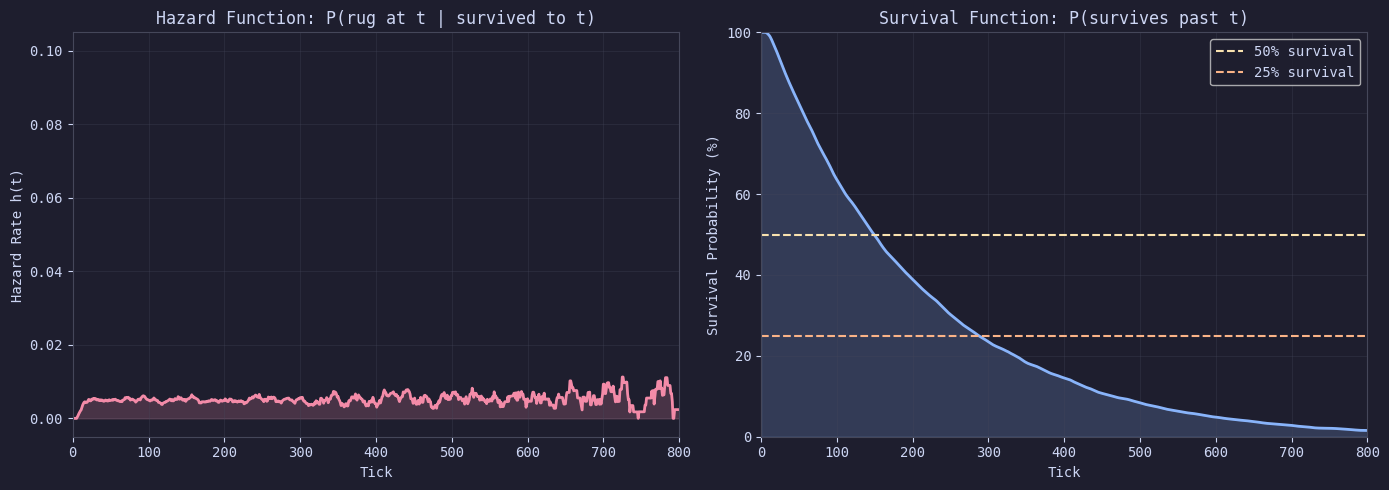


Survival Probabilities:
  S(50) = 82.3% (game survives past tick 50)
  S(100) = 63.6% (game survives past tick 100)
  S(200) = 38.9% (game survives past tick 200)
  S(300) = 23.5% (game survives past tick 300)
  S(500) = 8.4% (game survives past tick 500)


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ticks = np.arange(len(model.hazard_smooth))

# Hazard rate
axes[0].plot(ticks, model.hazard_smooth, color=C["red"], linewidth=2)
axes[0].fill_between(ticks, 0, model.hazard_smooth, color=C["red"], alpha=0.2)
axes[0].set_xlabel("Tick")
axes[0].set_ylabel("Hazard Rate h(t)")
axes[0].set_title("Hazard Function: P(rug at t | survived to t)")
axes[0].set_xlim(0, 800)
axes[0].grid(True)

# Survival function
axes[1].plot(ticks, model.survival * 100, color=C["blue"], linewidth=2)
axes[1].fill_between(ticks, 0, model.survival * 100, color=C["blue"], alpha=0.2)
axes[1].axhline(50, color=C["yellow"], linestyle="--", label="50% survival")
axes[1].axhline(25, color=C["peach"], linestyle="--", label="25% survival")
axes[1].set_xlabel("Tick")
axes[1].set_ylabel("Survival Probability (%)")
axes[1].set_title("Survival Function: P(survives past t)")
axes[1].set_xlim(0, 800)
axes[1].set_ylim(0, 100)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Key survival points
print("\nSurvival Probabilities:")
for t in [50, 100, 200, 300, 500]:
    if t < len(model.survival):
        print(f"  S({t}) = {model.survival[t]:.1%} (game survives past tick {t})")

---
## 3. Win Probability by Entry Tick

For a sidebet with a 40-tick window, what's the probability of winning at each entry tick?

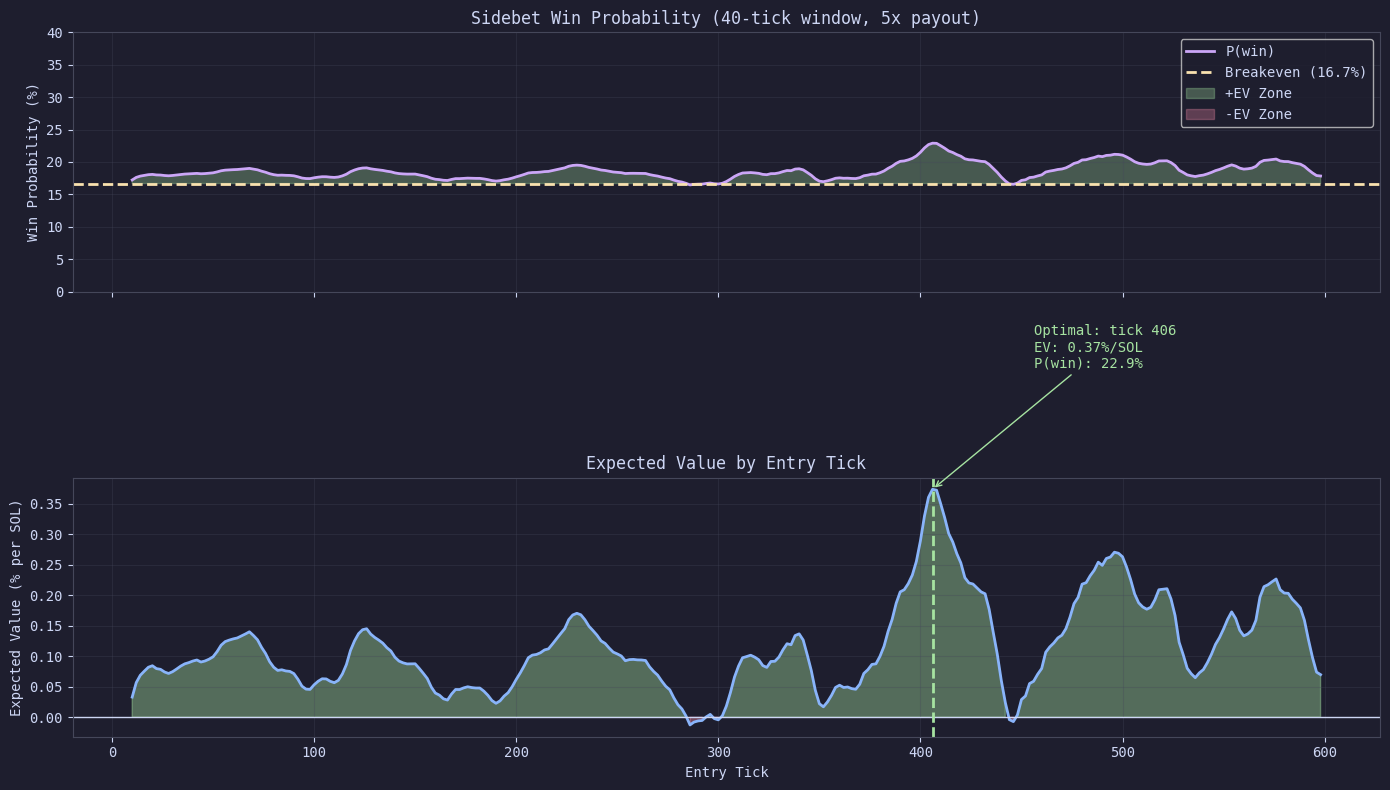

In [7]:
# Calculate win probability at each tick
tick_range = np.arange(10, 600, 2)
p_wins = [model.p_rug_in_window(t, SIDEBET_WINDOW) for t in tick_range]
evs = [ev(p, PAYOUT_MULT) for p in p_wins]
be = breakeven(PAYOUT_MULT)

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Win probability
axes[0].plot(tick_range, np.array(p_wins) * 100, color=C["mauve"], linewidth=2, label="P(win)")
axes[0].axhline(
    be * 100, color=C["yellow"], linestyle="--", linewidth=2, label=f"Breakeven ({be:.1%})"
)
axes[0].fill_between(
    tick_range,
    be * 100,
    np.array(p_wins) * 100,
    where=np.array(p_wins) > be,
    color=C["green"],
    alpha=0.3,
    label="+EV Zone",
)
axes[0].fill_between(
    tick_range,
    be * 100,
    np.array(p_wins) * 100,
    where=np.array(p_wins) <= be,
    color=C["red"],
    alpha=0.3,
    label="-EV Zone",
)
axes[0].set_ylabel("Win Probability (%)")
axes[0].set_title(f"Sidebet Win Probability ({SIDEBET_WINDOW}-tick window, {PAYOUT_MULT}x payout)")
axes[0].legend(loc="upper right")
axes[0].grid(True)
axes[0].set_ylim(0, 40)

# Expected value
evs_pct = np.array(evs) * 1000  # Per SOL
axes[1].plot(tick_range, evs_pct, color=C["blue"], linewidth=2)
axes[1].axhline(0, color=C["text"], linewidth=1)
axes[1].fill_between(tick_range, 0, evs_pct, where=evs_pct > 0, color=C["green"], alpha=0.4)
axes[1].fill_between(tick_range, 0, evs_pct, where=evs_pct <= 0, color=C["red"], alpha=0.4)

# Mark optimal entry
best_idx = np.argmax(evs)
best_tick = tick_range[best_idx]
best_ev = evs[best_idx]
best_p = p_wins[best_idx]
axes[1].axvline(best_tick, color=C["green"], linestyle="--", linewidth=2)
axes[1].annotate(
    f"Optimal: tick {best_tick}\nEV: {best_ev * 1000:.2f}%/SOL\nP(win): {best_p:.1%}",
    xy=(best_tick, best_ev * 1000),
    xytext=(best_tick + 50, best_ev * 1000 + 0.2),
    fontsize=10,
    color=C["green"],
    arrowprops=dict(arrowstyle="->", color=C["green"]),
)

axes[1].set_xlabel("Entry Tick")
axes[1].set_ylabel("Expected Value (% per SOL)")
axes[1].set_title("Expected Value by Entry Tick")
axes[1].grid(True)

plt.tight_layout()
plt.show()

---
## 4. Entry Zone Heatmap

How does EV change with different entry ticks AND different window sizes?

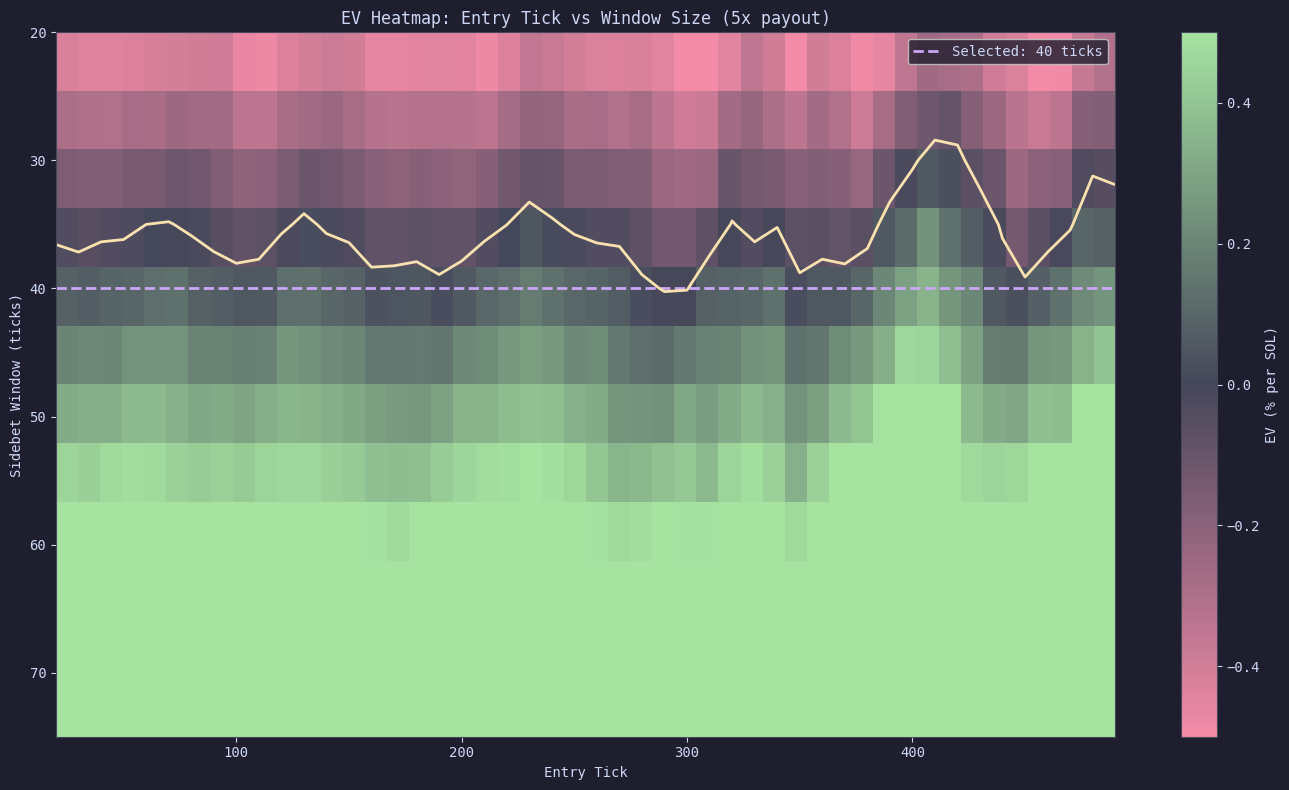


Interpretation:
  GREEN = Positive EV (good to bet)
  RED = Negative EV (avoid betting)
  YELLOW LINE = Breakeven contour (EV = 0)


In [8]:
# Create heatmap data
tick_vals = np.arange(20, 500, 10)
window_vals = np.arange(20, 80, 5)

ev_matrix = np.zeros((len(window_vals), len(tick_vals)))
for i, w in enumerate(window_vals):
    for j, t in enumerate(tick_vals):
        p = model.p_rug_in_window(int(t), int(w))
        ev_matrix[i, j] = ev(p, PAYOUT_MULT) * 1000  # % per SOL

fig, ax = plt.subplots(figsize=(14, 8))

# Custom colormap: red -> gray -> green
from matplotlib.colors import LinearSegmentedColormap

colors = [C["red"], "#45475a", C["green"]]
cmap = LinearSegmentedColormap.from_list("ev_cmap", colors, N=256)

im = ax.imshow(
    ev_matrix,
    aspect="auto",
    cmap=cmap,
    extent=[tick_vals[0], tick_vals[-1], window_vals[-1], window_vals[0]],
    vmin=-0.5,
    vmax=0.5,
)

# Highlight current window
ax.axhline(
    SIDEBET_WINDOW,
    color=C["mauve"],
    linestyle="--",
    linewidth=2,
    label=f"Selected: {SIDEBET_WINDOW} ticks",
)

# Contour at EV = 0 (breakeven)
ax.contour(tick_vals, window_vals, ev_matrix, levels=[0], colors=[C["yellow"]], linewidths=2)

ax.set_xlabel("Entry Tick")
ax.set_ylabel("Sidebet Window (ticks)")
ax.set_title(f"EV Heatmap: Entry Tick vs Window Size ({PAYOUT_MULT}x payout)")
ax.legend(loc="upper right")

cbar = plt.colorbar(im, ax=ax, label="EV (% per SOL)")

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  GREEN = Positive EV (good to bet)")
print("  RED = Negative EV (avoid betting)")
print("  YELLOW LINE = Breakeven contour (EV = 0)")

---
## 5. Kelly Criterion Bet Sizing

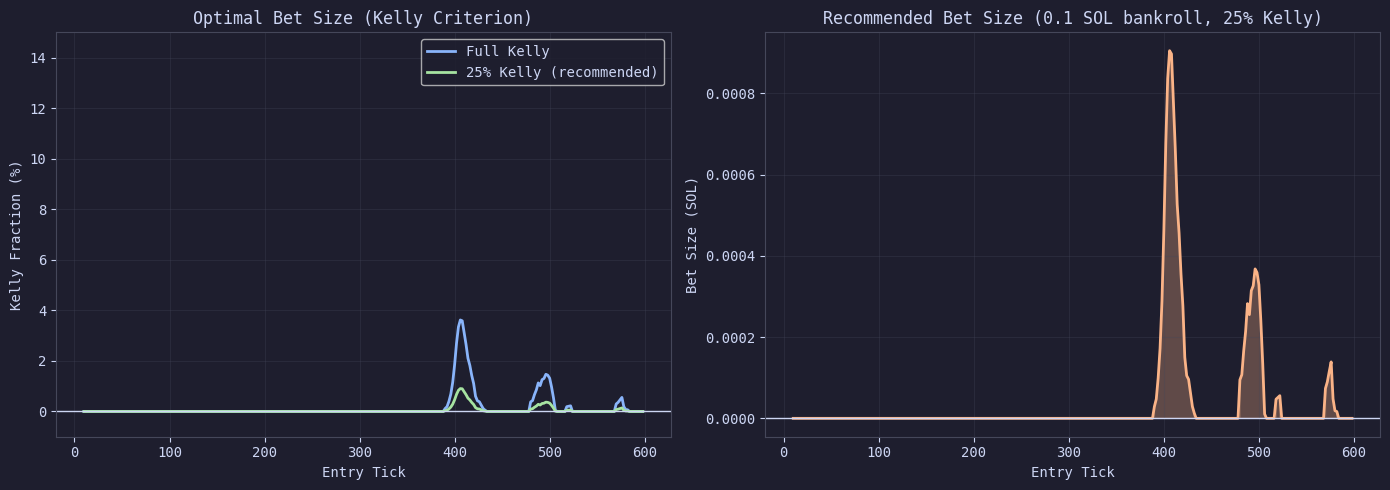

In [9]:
# Kelly sizing across tick range
kellys = [kelly(p, PAYOUT_MULT) for p in p_wins]
kellys_fractional = [k * KELLY_FRACTION for k in kellys]
bet_sizes = [k * BANKROLL for k in kellys_fractional]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Kelly fraction by tick
axes[0].plot(tick_range, np.array(kellys) * 100, color=C["blue"], linewidth=2, label="Full Kelly")
axes[0].plot(
    tick_range,
    np.array(kellys_fractional) * 100,
    color=C["green"],
    linewidth=2,
    label=f"{KELLY_FRACTION * 100:.0f}% Kelly (recommended)",
)
axes[0].axhline(0, color=C["text"], linewidth=1)
axes[0].set_xlabel("Entry Tick")
axes[0].set_ylabel("Kelly Fraction (%)")
axes[0].set_title("Optimal Bet Size (Kelly Criterion)")
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(-1, 15)

# Actual bet size in SOL
axes[1].plot(tick_range, bet_sizes, color=C["peach"], linewidth=2)
axes[1].fill_between(
    tick_range, 0, bet_sizes, where=np.array(bet_sizes) > 0, color=C["peach"], alpha=0.3
)
axes[1].axhline(0, color=C["text"], linewidth=1)
axes[1].set_xlabel("Entry Tick")
axes[1].set_ylabel("Bet Size (SOL)")
axes[1].set_title(
    f"Recommended Bet Size ({BANKROLL} SOL bankroll, {KELLY_FRACTION * 100:.0f}% Kelly)"
)
axes[1].grid(True)

plt.tight_layout()
plt.show()

---
## 6. Strategy Summary

In [10]:
# Find optimal entry zone
positive_ev_ticks = tick_range[np.array(evs) > 0]
optimal_bet = kelly(best_p, PAYOUT_MULT) * KELLY_FRACTION * BANKROLL

print("=" * 70)
print("                    SIDEBET STRATEGY SUMMARY")
print("=" * 70)
print("\n  Configuration:")
print(f"    Sidebet Window:  {SIDEBET_WINDOW} ticks")
print(f"    Payout:          {PAYOUT_MULT}x")
print(f"    Bankroll:        {BANKROLL} SOL")
print(f"    Kelly Fraction:  {KELLY_FRACTION * 100:.0f}%")

print("\n  Key Thresholds:")
print(f"    Breakeven P(win): {breakeven(PAYOUT_MULT):.2%}")

print("\n  Optimal Entry:")
print(f"    Best Tick:       {best_tick}")
print(f"    P(win):          {best_p:.2%}")
print(f"    EV:              {best_ev * 1000:+.2f}% per SOL")
print(
    f"    Recommended Bet: {optimal_bet:.6f} SOL ({optimal_bet / BANKROLL * 100:.2f}% of bankroll)"
)

if len(positive_ev_ticks) > 0:
    print("\n  Positive EV Zone:")
    print(f"    Entry Range:     tick {positive_ev_ticks.min()} - {positive_ev_ticks.max()}")
else:
    print("\n  WARNING: No positive EV zone found for this configuration!")

print("\n  Rules:")
print("    PLACE sidebet when:")
print(
    f"      - Game age > {positive_ev_ticks.min() if len(positive_ev_ticks) > 0 else 'N/A'} ticks"
)
print(f"      - P(win) > {breakeven(PAYOUT_MULT):.1%}")
print("\n    AVOID sidebet when:")
print("      - Game age < 100 ticks (instarug risk)")
print("      - Rapid price increase (momentum suggests pump continuing)")

print("\n" + "=" * 70)

                    SIDEBET STRATEGY SUMMARY

  Configuration:
    Sidebet Window:  40 ticks
    Payout:          5x
    Bankroll:        0.1 SOL
    Kelly Fraction:  25%

  Key Thresholds:
    Breakeven P(win): 16.67%

  Optimal Entry:
    Best Tick:       406
    P(win):          22.89%
    EV:              +0.37% per SOL
    Recommended Bet: 0.000905 SOL (0.90% of bankroll)

  Positive EV Zone:
    Entry Range:     tick 10 - 598

  Rules:
    PLACE sidebet when:
      - Game age > 10 ticks
      - P(win) > 16.7%

    AVOID sidebet when:
      - Game age < 100 ticks (instarug risk)
      - Rapid price increase (momentum suggests pump continuing)



---
## 7. Win Rate by Tick Range (Historical)

In [11]:
# Calculate actual historical win rates
tick_ranges = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500), (500, 800)]
results = []

for t_min, t_max in tick_ranges:
    # Games that survived to t_min
    eligible = df[df["rug_tick"] >= t_min]
    if len(eligible) == 0:
        continue

    # Games that rugged within window after entering this zone
    wins = eligible[
        (eligible["rug_tick"] >= t_min) & (eligible["rug_tick"] < t_min + SIDEBET_WINDOW)
    ]

    win_rate = len(wins) / len(eligible) if len(eligible) > 0 else 0
    ev_val = ev(win_rate, PAYOUT_MULT)

    results.append(
        {
            "Tick Range": f"{t_min}-{t_max}",
            "Eligible Games": len(eligible),
            "Win Rate": f"{win_rate:.1%}",
            "EV (% per SOL)": f"{ev_val * 1000:+.2f}%",
            "Status": "+EV" if ev_val > 0 else "-EV",
        }
    )

results_df = pd.DataFrame(results)
print("Historical Win Rates by Entry Tick Zone")
print(f"(Sidebet window: {SIDEBET_WINDOW} ticks, Payout: {PAYOUT_MULT}x)")
print()
print(results_df.to_string(index=False))

Historical Win Rates by Entry Tick Zone
(Sidebet window: 40 ticks, Payout: 5x)

Tick Range  Eligible Games Win Rate EV (% per SOL) Status
     0-100            2723    13.4%         -0.19%    -EV
   100-200            1731    17.6%         +0.06%    +EV
   200-300            1055    17.5%         +0.05%    +EV
   300-400             636    16.5%         -0.01%    -EV
   400-500             394    21.1%         +0.26%    +EV
   500-800             229    21.8%         +0.31%    +EV


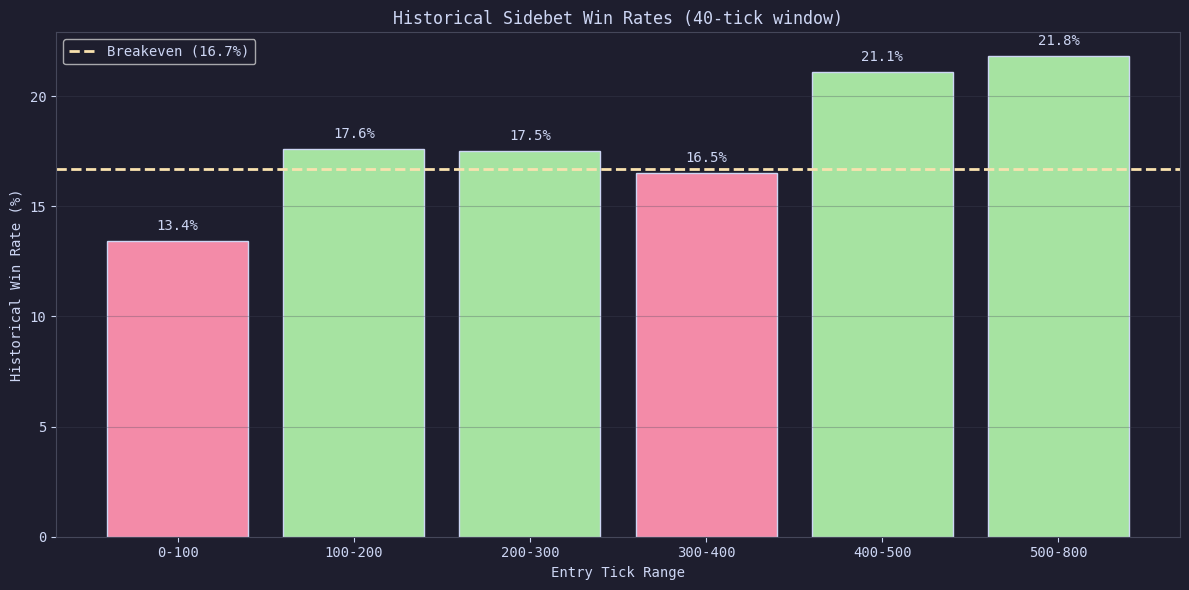

In [12]:
# Visualize historical win rates
fig, ax = plt.subplots(figsize=(12, 6))

x = [r["Tick Range"] for r in results]
win_rates = [float(r["Win Rate"].strip("%")) / 100 for r in results]
colors = [C["green"] if r["Status"] == "+EV" else C["red"] for r in results]

bars = ax.bar(x, np.array(win_rates) * 100, color=colors, edgecolor=C["text"], linewidth=1)
ax.axhline(
    breakeven(PAYOUT_MULT) * 100,
    color=C["yellow"],
    linestyle="--",
    linewidth=2,
    label=f"Breakeven ({breakeven(PAYOUT_MULT):.1%})",
)

ax.set_xlabel("Entry Tick Range")
ax.set_ylabel("Historical Win Rate (%)")
ax.set_title(f"Historical Sidebet Win Rates ({SIDEBET_WINDOW}-tick window)")
ax.legend()
ax.grid(True, axis="y")

# Add value labels
for bar, wr in zip(bars, win_rates):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{wr:.1%}",
        ha="center",
        fontsize=10,
        color=C["text"],
    )

plt.tight_layout()
plt.show()